# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [87]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

import spacy

nlp = spacy.load("en_core_web_sm")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install 

In [3]:
!nvidia-smi

Mon Oct 30 13:44:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P2              26W / 200W |   1725MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [191]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

In [5]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [6]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [7]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [8]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


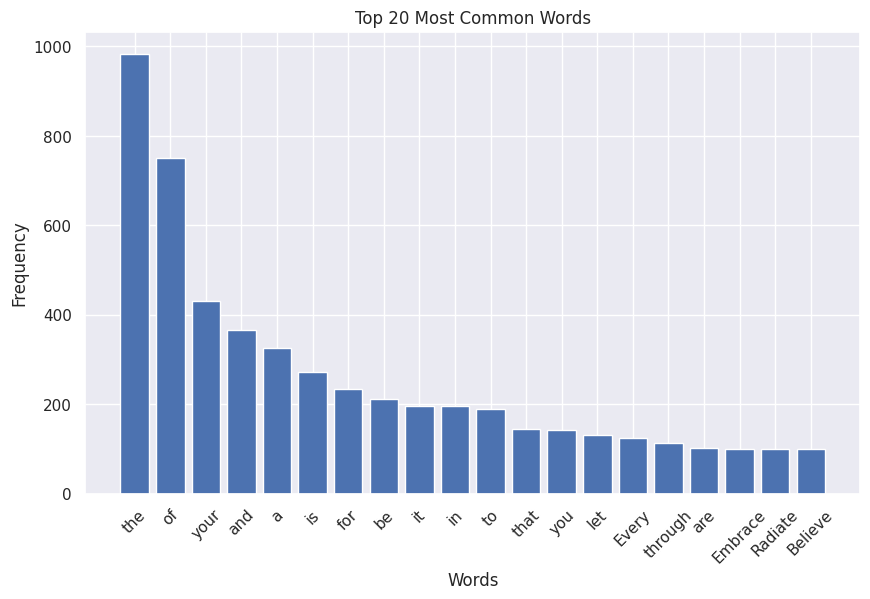

In [13]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [17]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [212]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

def keep_joint(sentence, joiner):
    output = [sentence[0]]
    for i, word in enumerate(sentence[1:]):
        if joiner in word:
            output.pop()
            output.append(sentence[i-1]+word)
            print(i, sentence)
        else:
            output.append(word)
    return output
            
def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = remove_punctuation(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences


In [242]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

for i in range(5):
    print(tokenized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=False)
tokenizer.fit_on_texts(tokenized_quotes)

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['Embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['Embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['Embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['Embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1202


In [228]:
contractions = []

for sequence in tokenized_quotes:
    for word in sequence:
        if "'" in word:
            contractions.append(word)

set(contractions)

{"'ll", "'s", "'ve"}

In [234]:
X = []
y = []

min_sequence_length = 2
for sequence in tokenized_quotes:
    for i in range(len(sequence)):
        for j in range(i+min_sequence_length, len(sequence)):
            X.append(" ".join(sequence[i:j]))
            y.append(sequence[j])
            if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                print(y[-1])

print(len(predictors))

for pred, label in zip(X[:5], y[:5]):
    print(f"Predictor: {pred}\nLabel: {label}")

X = tokenizer.texts_to_sequences(X)
y = tokenizer.texts_to_sequences(y)

max_sequence_length = 16
X = pad_sequences(X, maxlen=max_sequence_length, padding='pre')

for pred, label in zip(X[:5], y[:5]):
    print(f"Predictor: {pred}\nLabel: {label}")

y = to_categorical(y)

61889
Predictor: Embrace the
Label: beauty
Predictor: Embrace the beauty
Label: of
Predictor: Embrace the beauty of
Label: every
Predictor: Embrace the beauty of every
Label: sunrise
Predictor: Embrace the beauty of every sunrise
Label: it
Predictor: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  1]
Label: [56]
Predictor: [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  1 56]
Label: [2]
Predictor: [ 0  0  0  0  0  0  0  0  0  0  0  0 20  1 56  2]
Label: [47]
Predictor: [ 0  0  0  0  0  0  0  0  0  0  0 20  1 56  2 47]
Label: [94]
Predictor: [ 0  0  0  0  0  0  0  0  0  0 20  1 56  2 47 94]
Label: [10]


In [238]:
X.shape

(61603, 16)

In [239]:
y.shape

(61603, 1203)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, X_test, test_size=0.25, random_state=42)

In [247]:
# Build the model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))


Epoch 1/100
482/482 [==============================] - 24s 48ms/step - loss: 5.4322 - accuracy: 0.0779
Epoch 2/100
482/482 [==============================] - 19s 39ms/step - loss: 4.6012 - accuracy: 0.1688
Epoch 3/100
482/482 [==============================] - 18s 38ms/step - loss: 3.9615 - accuracy: 0.2564
Epoch 4/100
482/482 [==============================] - 19s 39ms/step - loss: 3.5587 - accuracy: 0.3212
Epoch 5/100
482/482 [==============================] - 18s 37ms/step - loss: 3.2518 - accuracy: 0.3642
Epoch 6/100
482/482 [==============================] - 17s 36ms/step - loss: 3.0091 - accuracy: 0.3960
Epoch 7/100
482/482 [==============================] - 19s 39ms/step - loss: 2.7976 - accuracy: 0.4275
Epoch 8/100
482/482 [==============================] - 18s 38ms/step - loss: 2.6095 - accuracy: 0.4549
Epoch 9/100
482/482 [==============================] - 18s 38ms/step - loss: 2.4426 - accuracy: 0.4791
Epoch 10/100
482/482 [==============================] - 19s 39ms/step - l

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_next_word(seed_text, next_words=1):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_index = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
    return seed_text

# Example usage
seed_text = "your input sequence goes here"
predicted_text = predict_next_word(seed_text, next_words=10)
print(predicted_text)